In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px  # to plot the time series plot
from sklearn import metrics  # for the evaluation
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf

In [102]:
data = pd.read_csv('metro_data.csv')
print(data)

      holiday    temp  rain_1h  snow_1h  clouds_all  weather_main  \
0        None  288.28      0.0      0.0          40        Clouds   
1        None  289.36      0.0      0.0          75        Clouds   
2        None  289.58      0.0      0.0          90        Clouds   
3        None  290.13      0.0      0.0          90        Clouds   
4        None  291.14      0.0      0.0          75        Clouds   
...       ...     ...      ...      ...         ...           ...   
48199    None  283.45      0.0      0.0          75        Clouds   
48200    None  282.76      0.0      0.0          90        Clouds   
48201    None  282.73      0.0      0.0          90  Thunderstorm   
48202    None  282.09      0.0      0.0          90        Clouds   
48203    None  282.12      0.0      0.0          90        Clouds   

          weather_description            date_time  traffic_volume  
0            scattered clouds  2012-10-02 09:00:00            5545  
1               broken clouds  20

In [103]:
for i in data.select_dtypes('object').columns:
    le = LabelEncoder().fit(data[i])
    data[i] = le.transform(data[i])

X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()
X_data = X_scaler.fit_transform(data[['holiday', 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main',
                                      'weather_description', 'traffic_volume']]) # FIXME: traffic_volume cannot be correct here?
Y_data = Y_scaler.fit_transform(data[['traffic_volume']])

In [104]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [105]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = 30000
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

In [106]:
print('Multiple window of past history\n')
print(x_train[0])
print('\n Target horizon\n')
print(y_train[0])

Multiple window of past history

[[0.63636364 0.92972555 0.         0.         0.4        0.1
  0.64864865 0.76167582]
 [0.63636364 0.93320863 0.         0.         0.75       0.1
  0.05405405 0.62032967]
 [0.63636364 0.93391815 0.         0.         0.9        0.1
  0.51351351 0.65480769]
 [0.63636364 0.93569194 0.         0.         0.9        0.1
  0.51351351 0.69038462]
 [0.63636364 0.93894927 0.         0.         0.75       0.1
  0.05405405 0.67554945]
 [0.63636364 0.94081981 0.         0.         0.01       0.
  0.72972973 0.71167582]
 [0.63636364 0.94549618 0.         0.         0.01       0.
  0.72972973 0.76703297]
 [0.63636364 0.94772148 0.         0.         0.01       0.
  0.72972973 0.82623626]
 [0.63636364 0.9486245  0.         0.         0.2        0.1
  0.10810811 0.79546703]
 [0.63636364 0.94527042 0.         0.         0.2        0.1
  0.10810811 0.65521978]
 [0.63636364 0.93840101 0.         0.         0.2        0.1
  0.10810811 0.48612637]
 [0.63636364 0.93327313 

In [107]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True),
                                  input_shape=x_train.shape[-2:]),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(units=horizon),
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 48, 400)          334400    
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 48, 20)            8020      
                                                                 
 bidirectional_7 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 20)                6020      
                                                                 
 dense_14 (Dense)            (None, 20)                420       
                                                                 
 dropout_3 (Dropout)         (None, 20)               

In [108]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks = [early_stopings, checkpoint]

# history = lstm_model.fit(train_data, epochs=150, steps_per_epoch=100, validation_data=val_data,
#                          validation_steps=50, verbose=1, callbacks=callbacks)

history = lstm_model.fit(train_data, epochs=1, steps_per_epoch=100, validation_data=val_data,
                         validation_steps=50, verbose=1, callbacks=callbacks)

100/100 [==============================] - 278s 3s/step - loss: 0.1121 - val_loss: 0.0819


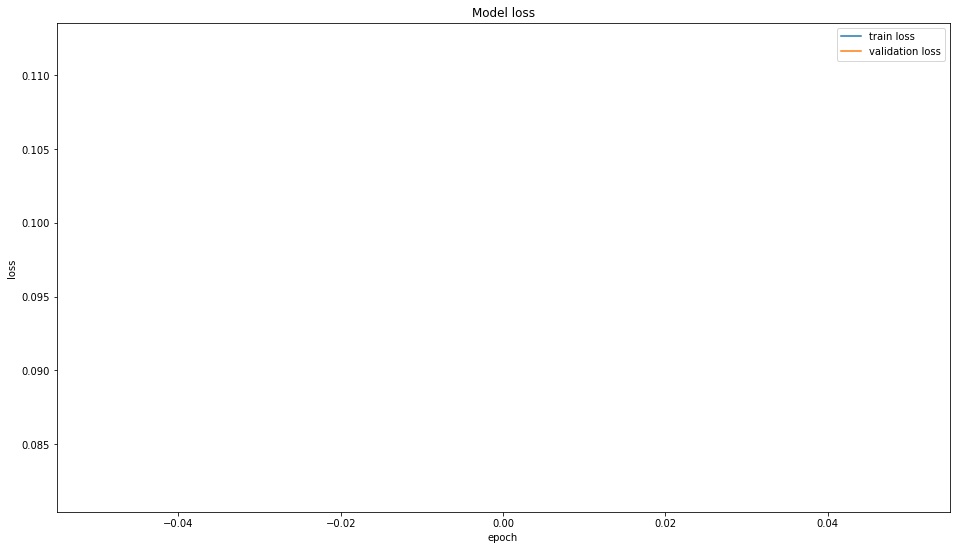

In [109]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()

In [110]:
data_val = X_scaler.fit_transform(data[['holiday', 'temp', 'rain_1h', 'snow_1h',
                                  'clouds_all', 'weather_main', 'weather_description', 'traffic_volume']].tail(48))
val_rescaled = data_val.reshape(1, data_val.shape[0], data_val.shape[1])
pred = lstm_model.predict(val_rescaled)
pred_Inverse = Y_scaler.inverse_transform(pred)
pred_Inverse

array([[1370.1715 ,  943.47314,  816.98346,  873.54803, 1227.539  ,
        1142.0763 , 1294.3225 , 1416.9834 , 1357.962  , 1308.0461 ]],
      dtype=float32)

In [111]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}', end='\n\n')

In [112]:
timeseries_evaluation_metrics_func(list(map(lambda el: el[0], data[["traffic_volume"]].tail(10).values)),pred_Inverse[0])

Evaluation metric results:-
MSE is : 5856062.21620122
MAE is : 2080.998681640625
RMSE is : 2419.930208952568
MAPE is : 57.39540800655669
R2 is : -3.035859064999128



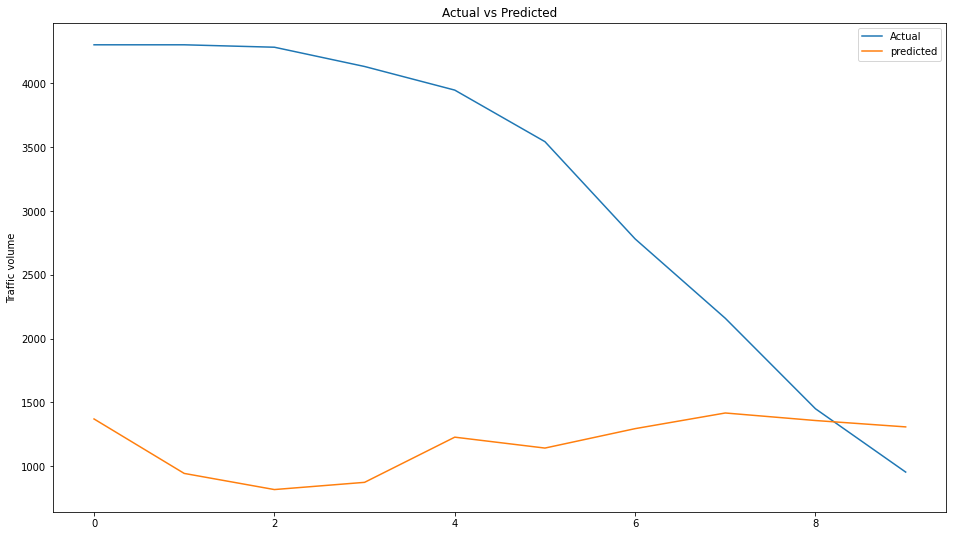

In [113]:
plt.figure(figsize=(16, 9))
plt.plot(list(map(lambda el: el[0], data[["traffic_volume"]].tail(10).values)))
plt.plot(list(pred_Inverse[0]))
plt.title("Actual vs Predicted")
plt.ylabel("Traffic volume")
plt.legend(('Actual', 'predicted'))
plt.show()